In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
%matplotlib inline
import matplotlib
sns.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (10,8)
matplotlib.rcParams['font.size']=20
matplotlib.rcParams['lines.linewidth']=4
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2

# Support Vector Machines (SVM)

## Theory

In [2]:
def _random_pt_in_circle(center, radius, num):
    angle = np.random.uniform(0, 2*np.pi, num)
    r = np.random.uniform(0,radius, num)
    return (r*np.vstack((np.cos(angle), np.sin(angle)))).T + center

In [3]:
m = 1
halfsep = 0.3

np.random.seed(2)

N = 100
x = np.random.uniform(-1,1, size=N)


y_cl1 = m*x + np.random.uniform(0,10, size=N) + halfsep
y_cl2 = m*x - np.random.uniform(0,10, size=N) - halfsep

# two misclassified points in upper cluster
idx_to_lower = np.random.randint(0, y_cl1.size, size=2)
y_cl1[idx_to_lower] = m*x[idx_to_lower] - np.random.uniform(0.6*halfsep,0.8*halfsep, size=2) + halfsep

# two misclassified points in lower cluster
idx_to_upper = np.random.randint(0, y_cl2.size, size=2)
y_cl2[idx_to_upper] = m*x[idx_to_upper] + np.random.uniform(0.6*halfsep,0.8*halfsep, size=2) - halfsep

cl1 = np.vstack((x, y_cl1)).T
cl2 = np.vstack((x, y_cl2)).T

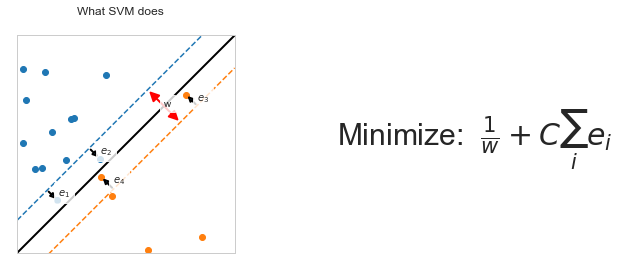

In [4]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_prop_cycle(None)
ax.scatter(cl1[:,0], cl1[:,1])
ax.scatter(cl2[:,0], cl2[:,1])


text_bbox_dict = dict(facecolor='white', alpha=0.8, ec='white')

all_x = np.linspace(-1,1,10)

ax.set_prop_cycle(None)
ax.plot(all_x, m*all_x + halfsep, '--', lw=1.5)
ax.plot(all_x, m*all_x - halfsep,  '--', lw=1.5)
ax.plot(all_x, m*all_x, c='black', lw=2)

x1 = 0.5
y_u = m*x1 + halfsep
y_l = m*x1 - halfsep

dx = halfsep
ax.annotate("", xy=(x1, y_l), xytext=(x1-dx,y_l+dx), arrowprops=dict(arrowstyle="<|-|>", ec='red', fc='red', mutation_scale=20, lw=2))
#ax.arrow(x1, y_l, -dx, dx, width=0.01, shape='full', ec='red', fc='red')
ax.text(x1-dx/2, y_l+dx/2, 'w', bbox=text_bbox_dict)

pts_beyond_upper = cl1[cl1[:,1]<m*cl1[:,0]+halfsep,:]
pts_beyond_lower = cl2[cl2[:,1]>m*cl2[:,0]-halfsep,:]

text_eps = 0.05

errnum = 0
for u,v in pts_beyond_upper:
    errnum += 1
    perpfoot = (u+v-halfsep)/2, (u+v+halfsep)/2
    ax.annotate("", xy=(u,v), xytext=perpfoot, arrowprops=dict(arrowstyle="-|>", lw=2))
    ax.text((u+perpfoot[0])/2+text_eps, (v+perpfoot[1])/2, r'$e_{%d}$'%errnum, bbox=text_bbox_dict)

for u,v in pts_beyond_lower:
    errnum += 1
    perpfoot = (u+v+halfsep)/2, (u+v-halfsep)/2
    ax.annotate("", xy=(u,v), xytext=perpfoot, arrowprops=dict(arrowstyle="-|>", lw=2))
    ax.text((u+perpfoot[0])/2+text_eps, (v+perpfoot[1])/2, r'$e_{%d}$'%errnum, bbox=text_bbox_dict)
    
# aesthetics
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xticks([])
ax.set_yticks([])


ax2 = fig.add_axes([1, 0.5, 0.1,0.1])
ax2.text(0,0, r"Minimize:  $\frac{1}{w}+C\sum_i e_i$", fontsize=30)

ax2.axis('off')
fig.suptitle('What SVM does')

fig.savefig('svm-schematics.svg')

## Regularization crucial for SVM
**Low** $C\Rightarrow$ decision planes **farther apart**.

**High** $C\Rightarrow$ decision planes **closer**, more **squiggly**.  

## Power of SVM: nonlinear decision planes
![title](images/svm-schematics.svg)

Examples of kernels:

| kernel | formula | params |
|--------|--------|---------|
| `linear` |     $\vec{x_1}\cdot\vec{x_2}$   |   |
| `poly` | $(\gamma\vec{x_1}\cdot\vec{x_2}+r)^d$ |
| `rbf`  | $exp(-\gamma |\vec{x_1} - \vec{x_2}|^2)$| 
    

## See in an (artificial) example

In [5]:
# create artificial features and labels
n_sample = 200
features = np.random.uniform(low=-1, high=1, size=(n_sample, 2))

labels = features[:,1]*features[:,1] + features[:,0]*features[:,0] - 0.9
#labels -= labels.mean()
labels = np.where(labels+np.random.randn(*labels.shape)*0.3 > 0, 1, 0)

df = pd.DataFrame(features, columns = ['a', 'b'])
df.loc[:, 'label'] = labels

df.head()

,a,b,label
0,-0.747680,-0.497434,0
1,0.762471,0.806592,1
2,-0.424729,0.934226,1
3,0.336199,0.006014,0
4,-0.243995,-0.325263,0


In [6]:
## make each class of equal size

min_size = min(df[df['label']==1].shape[0], df[df['label']==0].shape[0])
class1 = df[df['label']==1].sample(min_size)
class2 = df[df['label']==0].sample(min_size)

df = pd.concat((class1, class2))

features = df.loc[:, ['a', 'b']].as_matrix()
labels = df.loc[:, 'label'].as_matrix()

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/dmanik/venvs/teaching/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


[]

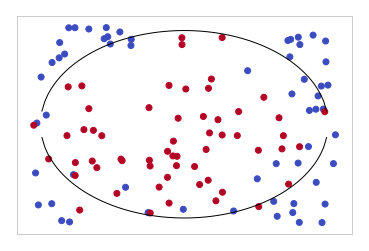

In [7]:
fig, ax = plt.subplots()

ax.scatter(x=df.loc[:, 'a'], y=df.loc[:, 'b'], c=df.loc[:, 'label'], cmap=plt.cm.coolwarm_r)

x_dummy = np.linspace(-1,1,100)
ax.plot(x_dummy, np.sqrt(0.9-x_dummy**2), c='k', lw=1)
ax.plot(x_dummy, -np.sqrt(0.9-x_dummy**2), c='k', lw=1)

ax.set_xticks([])
ax.set_yticks([])

**Unsurprisingly, logistic regression doesn't work well, as we will see**

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
training_data, test_data, training_labels, test_labels = train_test_split(features, labels, train_size=0.5, stratify=labels) # using stratify is important

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


** Reminder: *normalize first***

If  Feature A is in the range [0,1] and Feature B is in [10000,50000], SVM (in fact, most of the classifiers) will suffer inaccuracy.
The solution is to *normalize* (AKA "feature scaling") each feature to the same interval e.g. [0,1] or [-1, 1].

**scipy provides a standard function for this:**

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
# Fit only to the training data: IMPORTANT
scaler.fit(training_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression()
lr.fit(scaler.transform(training_data), training_labels)
lr.score(scaler.transform(test_data), test_labels)

0.5862068965517241

That's pretty bad.
* Solution 1: use feature engineering with logistic regression.
* Solution 2: SVM with `poly` kernel.

In [14]:
from sklearn.svm import SVC

### Fitting an SVM with `poly` kernel

In [15]:
clf = SVC(kernel='poly', degree=4, C=1, coef0=0.9)
clf.fit(scaler.transform(training_data), training_labels)
clf.score(scaler.transform(test_data), test_labels)

0.8103448275862069

### Visualize the decision boundary

In [16]:
# source: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


[]

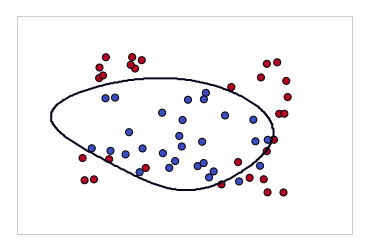

In [17]:
training_data_scaled = scaler.transform(training_data)


X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)

ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks([])
ax.set_yticks([])

### Using `GridSearchCV` for tuning the SVM

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
svr = SVC()
clf = GridSearchCV(svr, {'C':[0.1,1,10], 'coef0': np.linspace(-1,1,10), 'kernel': ['poly'], 'degree':[2,3,4]})

In [20]:
clf.fit(scaler.transform(training_data), training_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4], 'C': [0.1, 1, 10], 'kernel': ['poly'], 'coef0': array([-1.     , -0.77778, -0.55556, -0.33333, -0.11111,  0.11111,
        0.33333,  0.55556,  0.77778,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
clf.best_params_

{'C': 1, 'coef0': 0.7777777777777777, 'degree': 4, 'kernel': 'poly'}

In [22]:
svm_tuned = clf.best_estimator_

In [23]:
svm_tuned.fit(scaler.transform(training_data), training_labels)
svm_tuned.score(scaler.transform(test_data), test_labels)

0.8103448275862069

### How $C$ affects the decision boundary

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


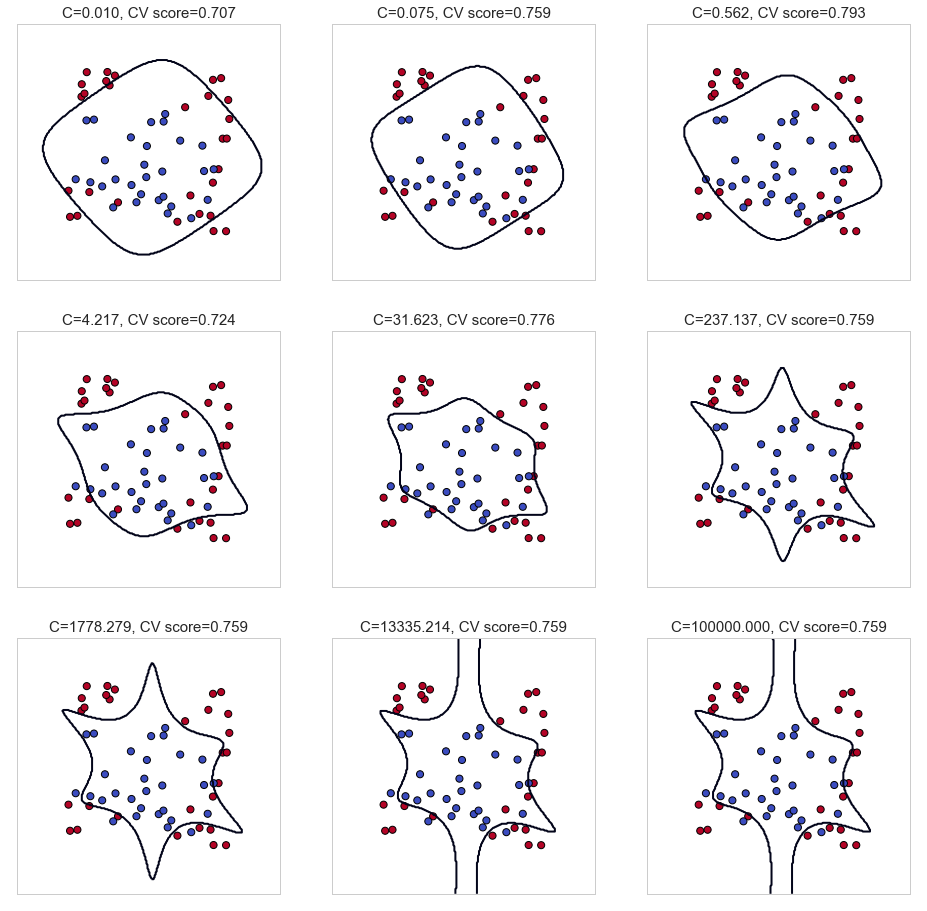

In [24]:
C_arr = np.logspace(-2, 5,9)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
axes = axes.reshape(-1,)

training_data_scaled = scaler.transform(training_data)
X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

for idx, c in enumerate(C_arr):
    ax = axes[idx]
    clf = SVC(kernel='poly', degree=6, C=c)
    clf.fit(scaler.transform(training_data), training_labels)
    score = clf.score(scaler.transform(test_data), test_labels)
    
    
    plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)
    ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title('C=%.3f, CV score=%.3f'%(c,score), fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

### Recap:
* SVM aims to draw two parallel planes. The planes should separate two classes. 
* SVM tries to maximize the distance between the parallel planes, at the same time penalizing points falling on the wrong side of the planes. 
* `poly` kernel enables SVM to draw nonlinear decision boundaries. 
* If C ("regularization parameter") is too high, decision boundaries get too curved, leading to overfitting. 

## Another nonlinear kernel: RBF  kernel

* Two parameters: $C$ and $\gamma$.
* $C$ is the regularization parameter: too high $C$ $\Rightarrow$ overfitting. 
* `gamma` specifies an "effective distance": features further than that do not affect each other. 

We take the same dataset

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/dmanik/venvs/teaching/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


[]

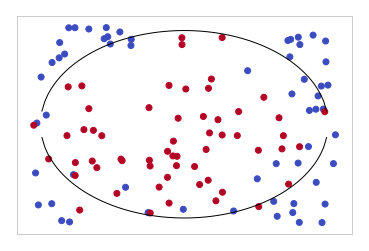

In [25]:
fig, ax = plt.subplots()

ax.scatter(x=df.loc[:, 'a'], y=df.loc[:, 'b'], c=df.loc[:, 'label'], cmap=plt.cm.coolwarm_r)

x_dummy = np.linspace(-1,1,100)
ax.plot(x_dummy, np.sqrt(0.9-x_dummy**2), c='k', lw=1)
ax.plot(x_dummy, -np.sqrt(0.9-x_dummy**2), c='k', lw=1)

ax.set_xticks([])
ax.set_yticks([])

### Fitting an SVM with `rbf` kernel

In [26]:
clf = SVC(kernel='rbf', C=1, gamma=1.5)
clf.fit(scaler.transform(training_data), training_labels)
clf.score(scaler.transform(test_data), test_labels)

0.8448275862068966

### Visualize the decision boundary

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


[]

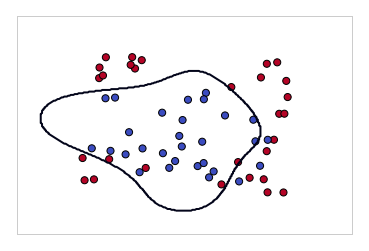

In [27]:
training_data_scaled = scaler.transform(training_data)


X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)

ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks([])
ax.set_yticks([])

### How does `gamma` influence the classifier?

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


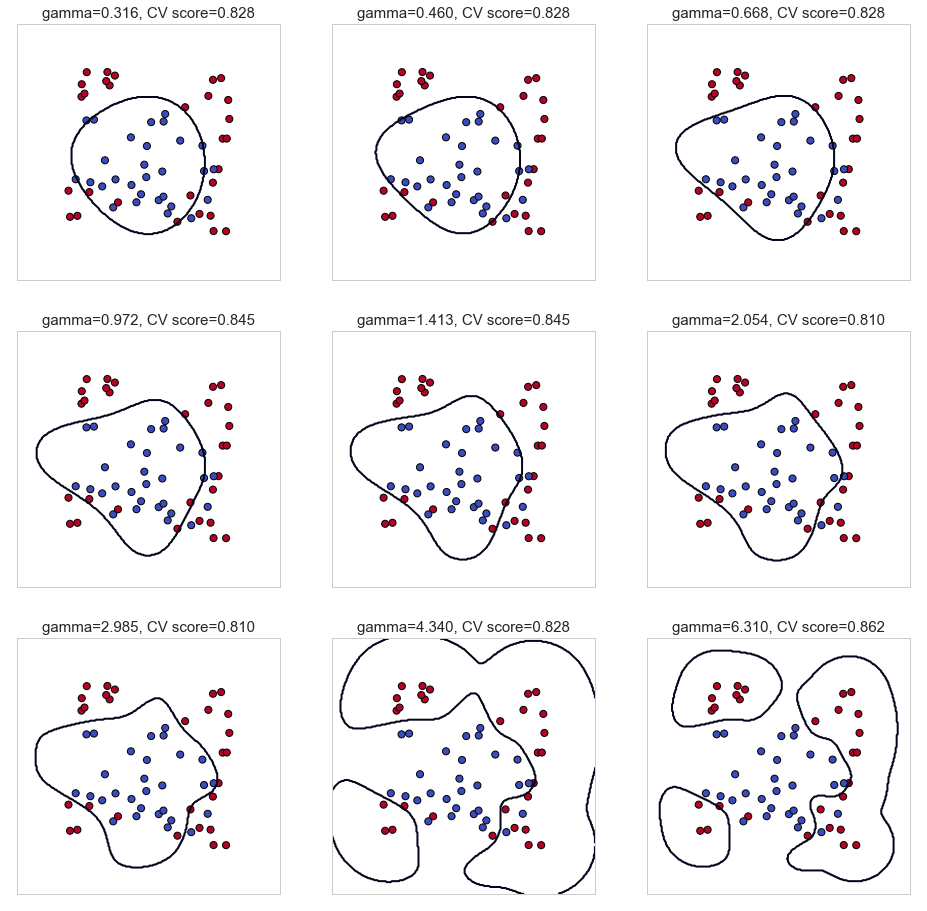

In [28]:
gamma_arr = np.logspace(-0.5, 0.8,9)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
axes = axes.reshape(-1,)

training_data_scaled = scaler.transform(training_data)
X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

for idx, gamma in enumerate(gamma_arr):
    ax = axes[idx]
    clf = SVC(kernel='rbf', C=1, gamma=gamma)
    clf.fit(scaler.transform(training_data), training_labels)
    score = clf.score(scaler.transform(test_data), test_labels)
    
    
    plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)
    ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title('gamma=%.3f, CV score=%.3f'%(gamma,score), fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

## Further reading:
* https://en.wikipedia.org/wiki/Support_vector_machine
* https://en.wikipedia.org/wiki/Kernel_method
* https://en.wikipedia.org/wiki/Radial_basis_function_kernel
* http://scikit-learn.org/stable/modules/svm.html#svc

# Some gory details of data wrangling

**Crucial techniques for data wrangling**
* missing data -> replace by central tendency/c.t.+random var
* bin continuous data <- use exploratory statistics
* sklearns polynomial feature generation

## Titanic stuff

In [29]:
tdata = sns.load_dataset('titanic')

In [30]:
tdata.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [31]:
categorical_features = ['class', 'sex', 'sibsp', 'parch', 'embark_town', 'adult_male', 'alone']

In [64]:
matplotlib.rcParams['font.size'] = 30

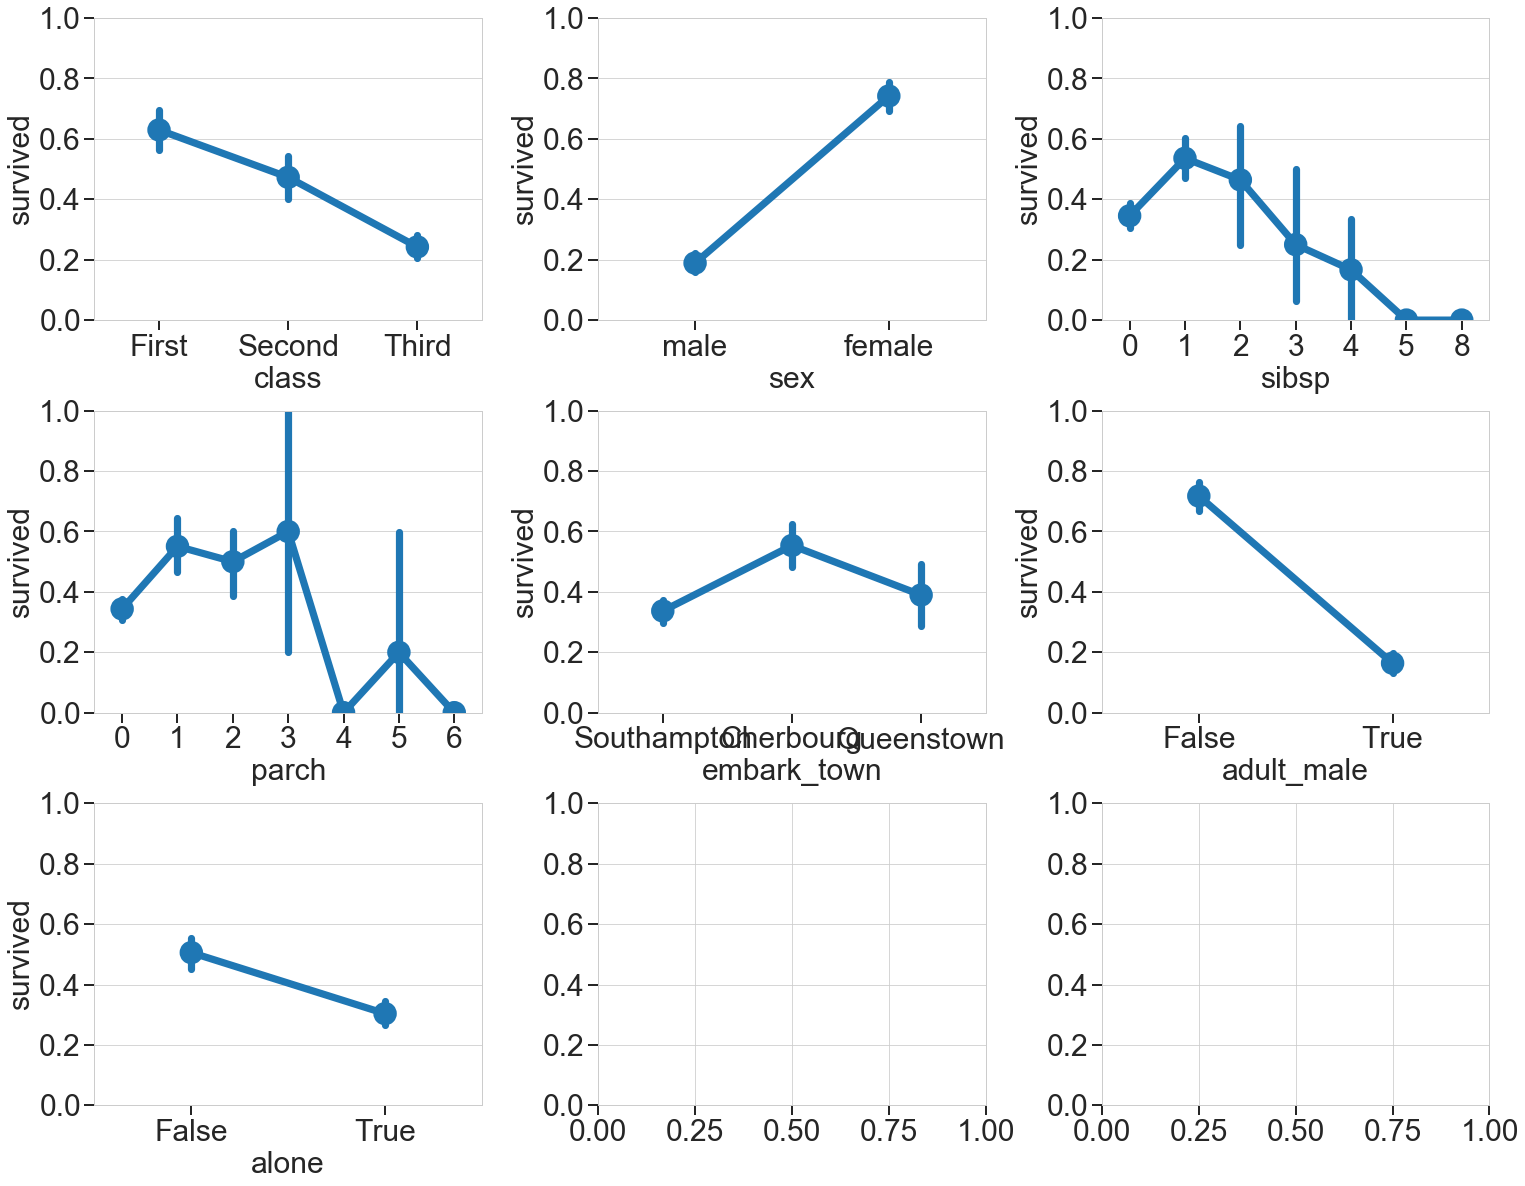

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,20), squeeze=False, gridspec_kw=dict(wspace=0.3, hspace=0.3))
axes = axes.reshape(-1,)

for idx, var in enumerate(categorical_features):
    sns.pointplot(data=tdata, x=var, y='survived', ax = axes[idx])
    axes[idx].set_ylim(0,1)

In [73]:
continuous_features = ['age', 'fare']

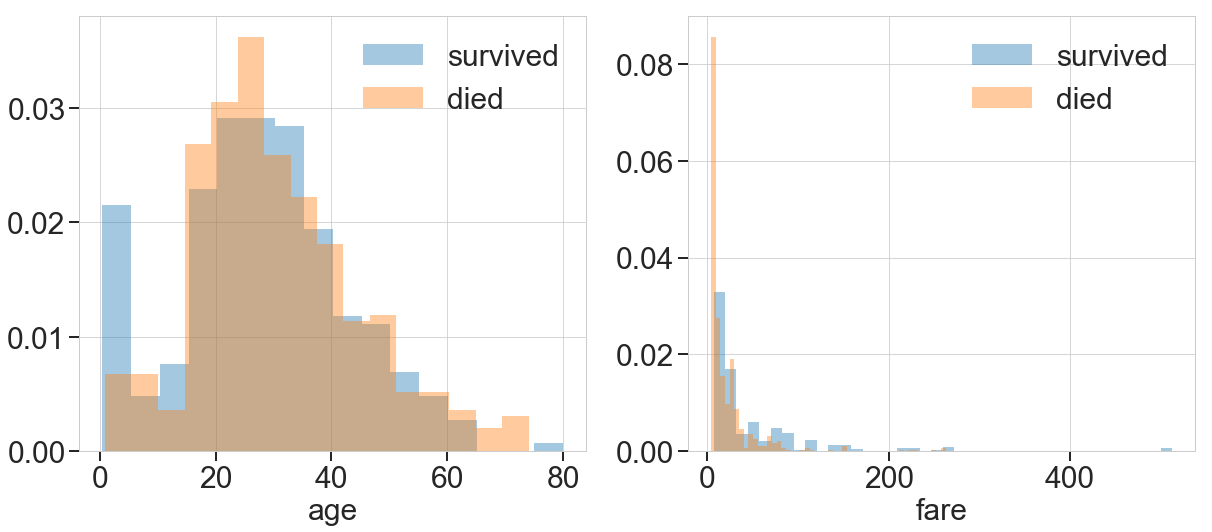

In [74]:
#fig, ax = plt.subplots(figsize=(12,8))

fig, axes = plt.subplots(1,2, figsize=(20,8))

for idx, var in enumerate(continuous_features):
    sns.distplot(tdata.loc[(tdata['survived']==True) & (tdata[var]>0), var], kde=False, label='survived', norm_hist=True, ax = axes[idx])
    sns.distplot(tdata.loc[(tdata['survived']==False) & (tdata[var]>0), var], kde=False, label='died', norm_hist=True, ax = axes[idx])
    axes[idx].legend()

## Feature extraction basic
* scale continuous features using `preprocessing.StandardScaler()`
* eliminate rows with missing values for any feature


## Feature extraction more advanced
* encode categorical features using `preprocessing.OneHotEncoder()`
* Imput missing values using `preprocessing.Imputer`
* Bin continuous features (thresholding).



In [35]:
categorical_features

['class', 'sex', 'sibsp', 'parch', 'embark_town', 'adult_male', 'alone']

In [36]:
continuous_features

['age', 'fare']

### drop all rows with missing values

In [37]:
data_pruned = tdata.loc[:, categorical_features+continuous_features+['survived']].dropna(how='any')
data_pruned.head()

,class,sex,sibsp,parch,embark_town,adult_male,alone,age,fare,survived
0,Third,male,1,0,Southampton,True,False,22.0,7.2500,0
1,First,female,1,0,Cherbourg,False,False,38.0,71.2833,1
2,Third,female,0,0,Southampton,False,True,26.0,7.9250,1
3,First,female,1,0,Southampton,False,False,35.0,53.1000,1
4,Third,male,0,0,Southampton,True,True,35.0,8.0500,0


### convert non-numeric categorical vars to numbers

In [38]:
data_pruned.loc[:, 'class'] = data_pruned['class'].apply(lambda x: ['First', 'Second', 'Third'].index(x))
data_pruned.loc[:, 'sex'] = data_pruned['sex'].apply(lambda x: ['male', 'female'].index(x))
data_pruned.loc[:, 'embark_town'] = data_pruned['embark_town'].apply(lambda x: ['Southampton', 'Queenstown', 'Cherbourg'].index(x))

In [39]:
cat_features = data_pruned.loc[:, categorical_features].as_matrix()
cont_features = data_pruned.loc[:, continuous_features].as_matrix()
cat_features_idxs = np.array(range(len(categorical_features)))
cont_features_idxs = np.array(range(len(continuous_features)))+len(categorical_features)

all_features = np.hstack((cat_features, cont_features))
labels = data_pruned.loc[:, 'survived']

### separate test data and training data

In [40]:
training_data, test_data, training_labels, test_labels = train_test_split(all_features, labels, train_size=0.5, stratify=labels)

cont_training_data, cat_training_data = training_data[:, cont_features_idxs], training_data[:, cat_features_idxs]
cont_test_data, cat_test_data = test_data[:, cont_features_idxs], test_data[:, cat_features_idxs]

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### feature scaling to continuous features

In [41]:
scaler = StandardScaler()
scaled_cont_training_data = scaler.fit_transform(cont_training_data)
scaled_cont_test_data = scaler.transform(cont_test_data)

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### add categorical data to scaled continuous data

In [42]:
processed_training_data = np.hstack((cat_training_data, scaled_cont_training_data))
processed_test_data = np.hstack((cat_test_data, scaled_cont_test_data))

### fit and score SVM

In [43]:
clf = SVC(random_state=0)
clf.fit(processed_training_data, training_labels)
clf.score(processed_test_data, test_labels)

0.7949438202247191

## Now try some additional preprocessing of features

### encode categorical values that are not orderable

In [44]:
categorical_features

['class', 'sex', 'sibsp', 'parch', 'embark_town', 'adult_male', 'alone']

In [45]:
cat_training_data[0,:]

array([0, 0, 1, 0, 0, True, False], dtype=object)

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, n_values=[3], categorical_features=[4])

In [47]:
# binarize embark_town 

cat_training_data_binarized, cat_test_data_binarized = cat_training_data.copy(), cat_test_data.copy()


cat_training_data_binarized[:, 4] = cat_training_data[:, 4] < 2
cat_test_data_binarized[:, 4] = cat_test_data[:, 4] < 2

In [48]:
scaled_cont_training_data = scaler.fit_transform(cont_training_data)
scaled_cont_test_data = scaler.transform(cont_test_data)

processed_training_data = np.hstack((cat_training_data_binarized, scaled_cont_training_data))
processed_test_data = np.hstack((cat_test_data_binarized, scaled_cont_test_data))

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [49]:
clf = SVC(random_state=0)
clf.fit(processed_training_data, training_labels)
clf.score(processed_test_data, test_labels)

0.7949438202247191

### Threshold on age

In [50]:
categorical_features, continuous_features

(['class', 'sex', 'sibsp', 'parch', 'embark_town', 'adult_male', 'alone'],
 ['age', 'fare'])

In [51]:
age_thres_training = (cont_training_data[:, 0]).reshape(-1,1) > 10
age_thres_test = (cont_test_data[:, 0]).reshape(-1,1) > 10

# scale the other cont vars
features_training_to_scale = cont_training_data[:, 1].reshape(-1,1)
features_test_to_scale = cont_test_data[:, 1].reshape(-1,1)

scaled_training_cont_data = scaler.fit_transform(features_training_to_scale)
scaled_test_cont_data = scaler.transform(features_test_to_scale)

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
processed_training_data = np.hstack((cat_training_data_binarized, age_thres_training,  scaled_training_cont_data))
processed_test_data = np.hstack((cat_test_data_binarized, age_thres_test, scaled_test_cont_data))

In [53]:
clf = SVC(random_state=0)
clf.fit(processed_training_data, training_labels)
clf.score(processed_test_data, test_labels)

0.7949438202247191

## imput missing values

In [54]:
for col in categorical_features+continuous_features:
    print(col, ": null values ", pd.isna(tdata[col]).sum()/tdata[col].size)

class : null values  0.0
sex : null values  0.0
sibsp : null values  0.0
parch : null values  0.0
embark_town : null values  0.002244668911335578
adult_male : null values  0.0
alone : null values  0.0
age : null values  0.19865319865319866
fare : null values  0.0


In [55]:
data_pruned = tdata.loc[:, categorical_features+continuous_features+['survived']]
data_pruned.head()

,class,sex,sibsp,parch,embark_town,adult_male,alone,age,fare,survived
0,Third,male,1,0,Southampton,True,False,22.0,7.2500,0
1,First,female,1,0,Cherbourg,False,False,38.0,71.2833,1
2,Third,female,0,0,Southampton,False,True,26.0,7.9250,1
3,First,female,1,0,Southampton,False,False,35.0,53.1000,1
4,Third,male,0,0,Southampton,True,True,35.0,8.0500,0


### convert non-numeric categorical vars to numbers

In [56]:
data_pruned.loc[:, 'class'] = data_pruned['class'].apply(lambda x: ['First', 'Second', 'Third'].index(x))
data_pruned.loc[:, 'sex'] = data_pruned['sex'].apply(lambda x: ['male', 'female'].index(x))
data_pruned.loc[:, 'embark_town'] = data_pruned['embark_town'].apply(lambda x: ['Southampton', 'Queenstown', 'Cherbourg'].index(x) if
                                                                     x is not np.nan else np.nan)

In [57]:
cat_features = data_pruned.loc[:, categorical_features].as_matrix().astype(float)
cont_features = data_pruned.loc[:, continuous_features].as_matrix().astype(float)
cat_features_idxs = np.array(range(len(categorical_features)))
cont_features_idxs = np.array(range(len(continuous_features)))+len(categorical_features)

all_features = np.hstack((cat_features, cont_features))
labels = data_pruned.loc[:, 'survived']

### separate test data and training data

In [58]:
training_data, test_data, training_labels, test_labels = train_test_split(all_features, labels, train_size=0.5, stratify=labels)

cont_training_data, cat_training_data = training_data[:, cont_features_idxs], training_data[:, cat_features_idxs]
cont_test_data, cat_test_data = test_data[:, cont_features_idxs], test_data[:, cat_features_idxs]

# copy orig for comparison later
cont_training_data_orig = cont_training_data.copy()
cat_training_data_orig = cat_training_data.copy()

cont_test_data_orig = cont_test_data.copy()
cat_test_data_orig = cat_test_data.copy()

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### imput missing `embark_town` values

In [59]:
from scipy.stats import itemfreq

In [60]:
itemfreq(training_data[:, categorical_features.index('embark_town')])

array([[  0., 313.],
       [  1.,  42.],
       [  2.,  89.],
       [ nan,   1.]])

In [61]:
cat_training_data[:, categorical_features.index('embark_town')] =\
    np.where(np.isnan(cat_training_data[:, categorical_features.index('embark_town')]), 0, 
             cat_training_data[:, categorical_features.index('embark_town')])
    
# ditto for test data
cat_test_data[:, categorical_features.index('embark_town')] =\
    np.where(np.isnan(cat_test_data[:, categorical_features.index('embark_town')]), 0, 
             cat_test_data[:, categorical_features.index('embark_town')])

### imput missing age and fare values

In [62]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [63]:
cont_training_data = imp.fit_transform(cont_training_data)

cont_test_data = imp.transform(cont_test_data)

In [175]:
scaler = StandardScaler()
scaled_cont_training_data = scaler.fit_transform(cont_training_data)
scaled_cont_test_data = scaler.transform(cont_test_data)

### add categorical data to scaled continuous data

In [176]:
processed_training_data = np.hstack((cat_training_data, scaled_cont_training_data))
processed_test_data = np.hstack((cat_test_data, scaled_cont_test_data))

### fit and score SVM

In [177]:
clf = SVC(random_state=0)
clf.fit(processed_training_data, training_labels)
clf.score(processed_test_data, test_labels)

0.8139013452914798